In [45]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, r2_score

# House price regression using TensorFlow

I have to: 

1) load the data

2) apply some basic feature engineering and cleaning

3) encode and normalize the data into something that can be efficiently computed by tensorflow

4) train the model, score it and compute metrics

5) check the model predictions visually

6) predict the house prices in the test set

Fore more info:

https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

https://www.tensorflow.org/tutorials/load_data/csv

https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers?authuser=2

https://www.tensorflow.org/guide/keras/preprocessing_layers

In [46]:
from house_prices import feat_eng

In [47]:
train=pd.read_csv('train.csv')

In [48]:
int_cat_f=['SaleCondition','ExterQual','Neighborhood','KitchenQual','SaleType','PoolQC','MSZoning']
int_num_f=['OverallQual','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea','GarageArea','YearBuilt','GarageCars','TotRmsAbvGrd','MSSubClass']


In [49]:
label='SalePrice'


### First implementation: only using numeric features and model.fit() method

In [50]:
feat_eng(train)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotFlrSF,nFlrs
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500,1710,2.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2007,WD,Normal,181500,1262,1.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,223500,1786,2.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,1717,2.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,12,2008,WD,Normal,250000,2198,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,8,2007,WD,Normal,175000,1647,2.0
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,MnPrv,NaN,0,2,2010,WD,Normal,210000,2073,1.0
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,GdPrv,Shed,2500,5,2010,WD,Normal,266500,2340,2.0
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,4,2010,WD,Normal,142125,1078,1.0


In [51]:
split_fraction=0.2
x,y=train.drop(label,axis=1),train[label]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split_fraction, random_state=0)

In [52]:
train_num_feat,test_num_feat=x_train[int_num_f],x_test[int_num_f]
train_num_feat=tf.convert_to_tensor(train_num_feat)
test_num_feat=tf.convert_to_tensor(test_num_feat)
y_test=tf.convert_to_tensor(y_test)
y_train=tf.convert_to_tensor(y_train)


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_num_feat)


In [53]:
train_num_feat

<tf.Tensor: shape=(1168, 10), dtype=int64, numpy=
array([[    9, 11694,    48, ...,     3,     9,    20],
       [    5,  6600,     0, ...,     1,     5,    20],
       [    5, 13360,   713, ...,     2,     5,    30],
       ...,
       [    6,  8930,     0, ...,     2,     8,    90],
       [    7,  3196,     0, ...,     2,     7,   120],
       [    7, 16770,     0, ...,     2,     7,    60]], dtype=int64)>

In [54]:
def get_basic_model():
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanSquaredLogarithmicError()])
    return model

Fitting the model:

In [55]:
model= get_basic_model()
history=model.fit(train_num_feat, y_train, epochs=10, batch_size=15,validation_data=(test_num_feat,y_test))


Epoch 1/10
78/78 [==============================] - 1s 11ms/step - loss: 38827937792.0000 - root_mean_squared_error: 197048.0469 - mean_squared_logarithmic_error: 86.7410 - val_loss: 39681626112.0000 - val_root_mean_squared_error: 199202.4844 - val_mean_squared_logarithmic_error: 42.5216
Epoch 2/10
78/78 [==============================] - 1s 8ms/step - loss: 37838782464.0000 - root_mean_squared_error: 194521.9375 - mean_squared_logarithmic_error: 24.2197 - val_loss: 36704202752.0000 - val_root_mean_squared_error: 191583.4062 - val_mean_squared_logarithmic_error: 11.5450
Epoch 3/10
78/78 [==============================] - 1s 8ms/step - loss: 30307106816.0000 - root_mean_squared_error: 174089.3594 - mean_squared_logarithmic_error: 6.4038 - val_loss: 22774300672.0000 - val_root_mean_squared_error: 150911.5625 - val_mean_squared_logarithmic_error: 2.6578
Epoch 4/10
78/78 [==============================] - 1s 9ms/step - loss: 13629627392.0000 - root_mean_squared_error: 116745.9922 - mean_sq

### Excercise 2: preprocess by using keras functional API

1) Build the preprocessing model, passing data as dict

2) numerical features should be normalized

3) categorical features should be one hot encoded

In [56]:
print(int_cat_f,int_num_f)

['SaleCondition', 'ExterQual', 'Neighborhood', 'KitchenQual', 'SaleType', 'PoolQC', 'MSZoning'] ['OverallQual', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'YearBuilt', 'GarageCars', 'TotRmsAbvGrd', 'MSSubClass']


In [57]:
inputs = {}
for name in int_num_f+int_cat_f:
    if name in int_num_f:
        dtype = tf.float32
    if (name in int_cat_f):
        dtype = tf.string
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
inputs

{'OverallQual': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'OverallQual')>,
 'LotArea': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'LotArea')>,
 'BsmtFinSF1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'BsmtFinSF1')>,
 'TotalBsmtSF': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'TotalBsmtSF')>,
 'GrLivArea': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'GrLivArea')>,
 'GarageArea': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'GarageArea')>,
 'YearBuilt': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'YearBuilt')>,
 'GarageCars': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'GarageCars')>,
 'TotRmsAbvGrd': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'TotRmsAbvGrd')>,
 'MSSubClass': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'MSSubClass')>,
 'SaleCondition': <KerasTensor: shape=(None, 1) dtype=string (created by

#### Numeric inputs:

Concatenate the numeric input layers:

In [58]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(train[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'normalization_4')>

In [59]:
preprocessed_inputs = [all_numeric_inputs]

#### Categorical inputs

In [60]:
for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue
  
    lookup = layers.StringLookup(vocabulary=np.unique(train[name]))
    one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

In [61]:
preprocessed_inputs

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'normalization_4')>,
 <KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'category_encoding_7')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_8')>,
 <KerasTensor: shape=(None, 26) dtype=float32 (created by layer 'category_encoding_9')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_10')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'category_encoding_11')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_12')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'category_encoding_13')>]

#### Create the preprocessing layer

In [62]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

house_prices_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

#tf.keras.utils.plot_model(model = house_prices_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

#### Create the model

In [63]:
def create_model(preprocessing_head, inputs:dict):
    preprocessed_inputs = preprocessing_head(inputs)
    x=tf.keras.layers.Dense(100,activation='relu')(preprocessed_inputs)
    x=tf.keras.layers.Dropout(0.25)(x)
    x=tf.keras.layers.Dense(150,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.25)(x)
    x=tf.keras.layers.Dense(100,activation='relu')(x)
    result = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, result)
    model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanSquaredLogarithmicError()])
    return model

house_price_model = create_model(house_prices_preprocessing, inputs)

In [64]:
print(house_price_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 BsmtFinSF1 (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 ExterQual (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 GarageArea (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 GarageCars (InputLayer)        [(None, 1)]          0           []                               
                                                                                            

In [95]:
#function to create train and validation dictionaries
def train_val(df:pd.DataFrame,val_fraction,feature_list,label,shuffle=False):
    '''returns the train and validation sets as dictionaries'''
    if shuffle==True:
        df=df.sample(frac=1)
    
    val_size=int(val_fraction*len(df))
    train_size=len(df)-val_size
    print('train size = ', train_size, '\nvalidation size = ', val_size)
    train_df=df.iloc[:train_size]
    val_df=df.iloc[train_size:]
    train_dict={name:np.array(train_df[name]) for name in feature_list}
    val_dict={name:np.array(val_df[name]) for name in feature_list}
    train_label=train_df[label]
    val_label=val_df[label]
    return train_dict,train_label,val_dict,val_label

In [66]:
train_features_dict={name:np.array(train[name]) for name in (int_num_f+int_cat_f)}


In [67]:
train_features_dict['SaleCondition']

array(['Normal', 'Normal', 'Normal', ..., 'Normal', 'Normal', 'Normal'],
      dtype=object)

In [68]:
house_prices_preprocessing(train_features_dict)

<tf.Tensor: shape=(1460, 74), dtype=float32, numpy=
array([[ 0.65147984, -0.20714168,  0.57542485, ...,  0.        ,
         1.        ,  0.        ],
       [-0.0718355 , -0.09188636,  1.1719922 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.65147984,  0.07347997,  0.09290722, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.65147984, -0.14781025, -0.36987108, ...,  0.        ,
         1.        ,  0.        ],
       [-0.7951509 , -0.08016039, -0.8655483 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.7951509 , -0.05811154,  0.8473894 , ...,  0.        ,
         1.        ,  0.        ]], dtype=float32)>

In [83]:
history2=house_price_model.fit(x=train_features_dict, y=train[label], epochs=100,batch_size=15,validation_split=split_fraction)

Epoch 1/100
78/78 [==============================] - 2s 21ms/step - loss: 0.0645 - root_mean_squared_error: 57461.3320 - mean_squared_logarithmic_error: 0.0645 - val_loss: 0.0530 - val_root_mean_squared_error: 59860.8828 - val_mean_squared_logarithmic_error: 0.0530
Epoch 2/100
78/78 [==============================] - 2s 20ms/step - loss: 0.0607 - root_mean_squared_error: 55997.8477 - mean_squared_logarithmic_error: 0.0607 - val_loss: 0.0501 - val_root_mean_squared_error: 58446.7578 - val_mean_squared_logarithmic_error: 0.0501
Epoch 3/100
78/78 [==============================] - 2s 21ms/step - loss: 0.0597 - root_mean_squared_error: 55209.3320 - mean_squared_logarithmic_error: 0.0597 - val_loss: 0.0477 - val_root_mean_squared_error: 57194.8438 - val_mean_squared_logarithmic_error: 0.0477
Epoch 4/100
78/78 [==============================] - 2s 20ms/step - loss: 0.0554 - root_mean_squared_error: 52869.0859 - mean_squared_logarithmic_error: 0.0554 - val_loss: 0.0457 - val_root_mean_squared

### Make predictions and score

In [84]:
def score_and_visualize(model,x_test,y_test):
    predictions=model.predict(x_test).flatten()
    print(predictions.shape)
    plt.figure(figsize=(10,10))
    plt.scatter(y_test,predictions)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    msle=mean_squared_log_error(y_true=y_test, y_pred=predictions)#msle is the metric evaluated in the kaggle challange
    r2=r2_score(y_true=y_test, y_pred=predictions)
    print('r2 coefficient: ',r2,'\nmsle = ', msle)
    z = np.polyfit(y_test, predictions, 1)
    print(z)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')
    plt.axline((0,0),slope=1,ls='--')
    plt.show()

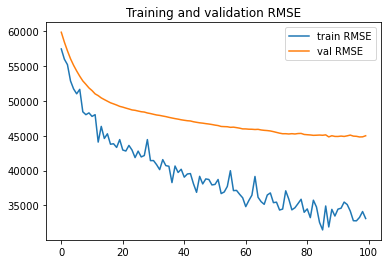

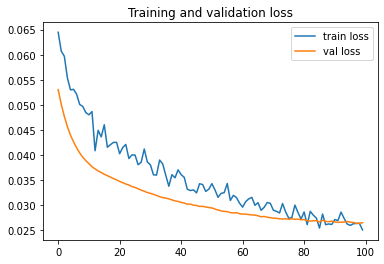

In [98]:
metric = history2.history['root_mean_squared_error']
val_metric = history2.history['val_root_mean_squared_error']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(metric))

plt.plot(epochs, metric,label='train RMSE')
plt.plot(epochs, val_metric,label='val RMSE')
plt.title('Training and validation RMSE')
plt.legend()
plt.figure()

plt.plot(epochs, loss,label='train loss')
plt.plot(epochs, val_loss,label='val loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [102]:
_,_,val_features_dict,val_label=train_val(train,0.2,(int_num_f+int_cat_f),label=label,shuffle=True)

train size =  1168 
validation size =  292


10/10 [==============================] - 0s 17ms/step
(292,)
r2 coefficient:  0.9044160583684147 
msle =  0.014742696265277612
[8.89538958e-01 1.99404115e+04]


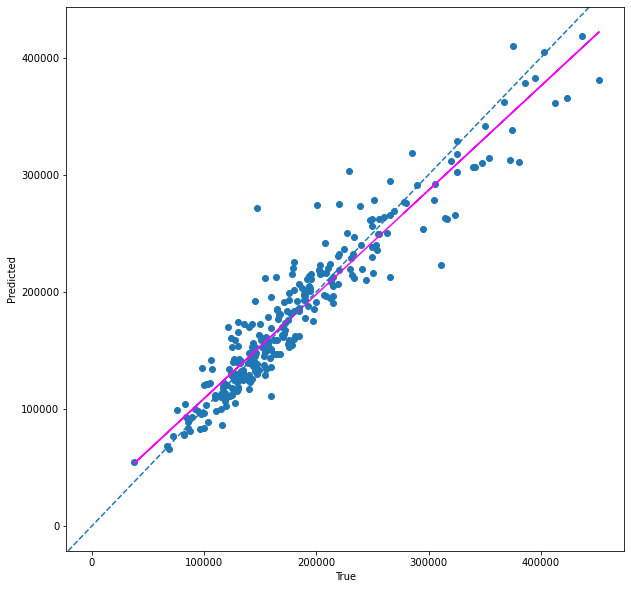

In [103]:
score_and_visualize(model=house_price_model,x_test=val_features_dict,y_test=val_label)


Save predictions

In [105]:
import datetime

In [106]:
write=True

test=pd.read_csv('test.csv')
test=test[int_num_f]
tf.convert_to_tensor(test)
pred=model.predict(test)
out_df=pd.read_csv('sample_submission.csv')
out_df['SalePrice']=pred
if write:
    out_df.to_csv('prediction_tf.csv',index=False)

46/46 [==============================] - 0s 3ms/step


In [107]:
test=feat_eng(pd.read_csv('test.csv'))
test[int_cat_f]=test[int_cat_f].fillna('none')
test[int_num_f]=test[int_num_f].fillna(-1)

In [108]:
test_feature_dict={name:np.array(test[name]) for name in (int_num_f+int_cat_f)}
for name in int_num_f:
    test_feature_dict[name]=tf.cast(test_feature_dict[name],tf.float32)

for name in int_cat_f:
    test_feature_dict[name]=tf.cast(test_feature_dict[name],tf.string)

pred=house_price_model.predict(test_feature_dict)
out_df=pd.read_csv('sample_submission.csv')
out_df['SalePrice']=pred
if write:
    out_df.to_csv('prediction_tf_allfeatures.csv',index=False)

46/46 [==============================] - 1s 11ms/step


Save model

In [109]:
savemodel=False
if savemodel:
    timestamp=datetime.datetime.now().strftime("%d%m%Y%H%M%S")
    models_folder= 'models'
    os.makedirs(models_folder,exist_ok=True)
    model_name= 'model_'+ timestamp +'_tf.h5'
    modelpath= os.path.join(models_folder,model_name)
    model.save(modelpath)
    print('Saved ' , modelpath)